In [1]:
!apt update > /dev/null && apt upgrade > /dev/null
!pip install kaggle > /dev/null



W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


Extracting templates from packages: 100%


In [2]:
import kagglehub
import os

# Download latest version
# path 현재 파일이 다운로드된 경로
path = kagglehub.dataset_download("computingvictor/transactions-fraud-datasets")

os.chdir(path) # 경로를 현재 다운로드된 파일들이 있는 경로로 변경
print(os.getcwd()) # 현재 폴더 경로; 작업 폴더 기준
print(os.listdir(os.getcwd()))

100%|██████████| 348M/348M [00:02<00:00, 174MB/s]

Extracting files...


/root/.cache/kagglehub/datasets/computingvictor/transactions-fraud-datasets/versions/1
['users_data.csv', 'train_fraud_labels.json', 'mcc_codes.json', 'cards_data.csv', 'transactions_data.csv']


필요한 부분을 병합 (사기여부, 성별)

fraud + client_id

In [5]:
import pandas as pd
import json

with open('train_fraud_labels.json') as f:
    js = json.loads(f.read())
fraud = pd.DataFrame(js)
fraud = fraud.reset_index()
fraud.columns = ["id", "fraud"]

fraud['id'] = fraud['id'].astype(str)
fraud['fraud'] = fraud['fraud'].astype(str)

file_path = "transactions_data.csv"
trans = pd.read_csv(file_path)
columns_to_keep = ["id", "client_id"]
# 특정 컬럼만 남기기
trans = trans[columns_to_keep]

trans['id'] = trans['id'].astype(str)
trans['client_id'] = trans['client_id'].astype(str)

merge = pd.merge(fraud, trans, on='id')

fraud + (client_id) + gender

In [10]:
file_path = "users_data.csv"
card = pd.read_csv(file_path)

columns_to_keep = ["id", "gender"]

# 특정 컬럼만 남기기
card = card[columns_to_keep]

print(card.head())
print(card.dtypes)

card['id'] = card['id'].astype(str)
card['gender'] = card['gender'].astype(str)

card.columns = ["client_id", "gender"] # 다른 파일들에선 client_id = 현 파일에서의 id

     id  gender
0   825  Female
1  1746  Female
2  1718  Female
3   708  Female
4  1164    Male
id         int64
gender    object
dtype: object


In [11]:
merge = pd.merge(merge, card, on='client_id')

In [13]:
print(merge.head())
columns_to_keep = ["fraud", "gender"]
# 특정 컬럼만 남기기
merge = merge[columns_to_keep]
print(merge.head())

         id fraud client_id  gender
0  10649266    No        11  Female
1  23410063    No       609    Male
2   9316588    No      1094    Male
3  12478022    No       944    Male
4   9558530    No       895  Female
  fraud  gender
0    No  Female
1    No    Male
2    No    Male
3    No    Male
4    No  Female


사기를 당한 전체 비율 중 남성과 여성의 비율을 pie chart로 시각화

사기당한 횟수:
여성: 6982회
남성: 6350회


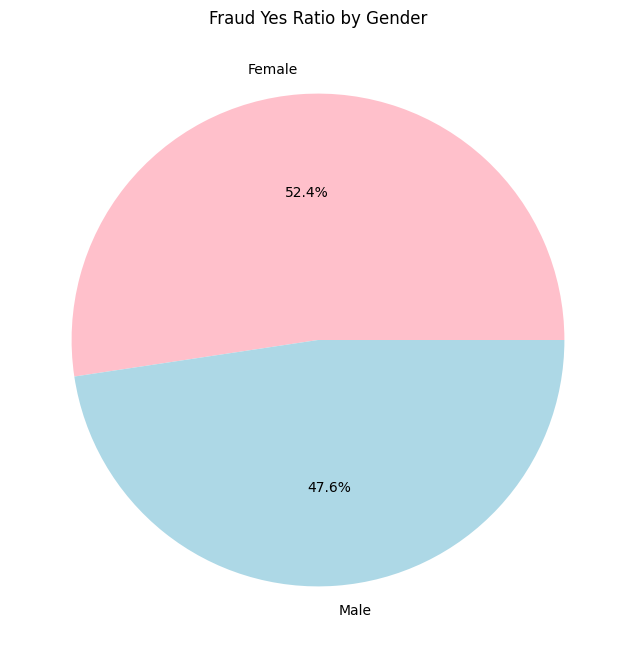

In [14]:
import matplotlib.pyplot as plt

# 사기 여부가 'Yes'인 경우만 필터링
fraud_counts = merge[merge["fraud"] == "Yes"].groupby("gender").size()

# 여성과 남성이 사기당한 횟수 CLI 출력
print("사기당한 횟수:")
print(f"여성: {fraud_counts.get('Female', 0)}회")
print(f"남성: {fraud_counts.get('Male', 0)}회")

# 전체 사기 횟수에서 성별 비율 계산
fraud_ratios = fraud_counts / fraud_counts.sum()

# 파이 차트 그리기
plt.figure(figsize=(8, 8))
fraud_ratios.plot(kind='pie', autopct='%1.1f%%', labels=["Female", "Male"], colors=["pink", "lightblue"])
plt.title("Fraud Yes Ratio by Gender")
plt.ylabel("")  # y축 라벨 제거
plt.show()